### SMS Spam Detection

<p>You are hired as an AI expert in the development department of a telecommunications company. The first thing on your orientation plan is a small project that your boss has assigned you for the following given situation. Your supervisor has given away his private cell phone number on too many websites and is now complaining about daily spam SMS. Therefore, it is your job to write a spam detector in Python. </p>

<p>In doing so, you need to use a Naive Bayes classifier that can handle both bag-of-words (BoW) and tf-idf features as input. For the evaluation of your spam detector, an SMS collection is available as a dataset - this has yet to be suitably split into train and test data. To keep the costs as low as possible and to avoid problems with copyrights, your boss insists on a new development with Python.</p>

<p>Include a short description of the data preprocessing steps, method, experiment design, hyper-parameters, and evaluation metric. Also, document your findings, drawbacks, and potential improvements.</p>

<p>Note: You need to implement the bag-of-words (BoW) and tf-idf feature extractor from scratch. You can use existing python libraries for other tasks.</p>

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [ ]:
import string
import contractions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
import pandas as pd
import re
import math

def preprocess(text):
    text = contractions.fix(text) # I'm -> I am
    text = text.lower()
    text = re.sub(r'\.\.+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.split()

def bag_of_words(documents):
    word_counts = []
    size = len(documents)
    vocab = {}
    for doc in documents:
        words = preprocess(doc)
        for word in words:
            if word not in vocab:
                vocab[word] = len(vocab)

    for i in range(size):
        word_list = [0] * len(vocab)
        lst = preprocess(documents[i])
        for word in lst:
            if word in vocab:
                word_list[vocab[word]] += 1
        word_counts.append(word_list)

    return word_counts


def tf_idf(documents):
    vocab = {}
    doc_count = len(documents)
    doc_words = [preprocess(doc) for doc in documents]

    for doc in doc_words:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab)

    #document frequency
    df = [0] * len(vocab)
    for word, idx in vocab.items():
        for doc in doc_words:
            if word in doc:
                df[idx] += 1

    #IDF
    idf = [0] * len(vocab)
    for word, idx in vocab.items():
        idf[idx] = math.log(doc_count / 1 + df[idx])

    #TF-IDF vectors
    tf_idf_vectors = []
    for doc in doc_words:
        vec = [0] * len(vocab)
        word_freq = {}
        for word in doc:
            word_freq[word] = word_freq.get(word, 0) + 1
        for word in doc:
            idx = vocab[word]
            tf = word_freq[word] / len(doc)
            tf_idf_val = tf * idf[idx]
            vec[idx] = 1 if tf_idf_val > 0 else 0  # Convert to binary (1 if word present, 0 if absent)
        tf_idf_vectors.append(vec)

    return tf_idf_vectors

#### I left only 1000 sms from the dataset as the execution time was too high.
df = pd.read_csv("Assignmnet_2/sms_spam_collection/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])

model_flag = False
if (model_flag):
    features = bag_of_words(df['message'].tolist())
else:
    features = tf_idf(df["message"].tolist())

X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=42)

# Naive Bayes classifier
model = BernoulliNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       177
        spam       1.00      0.70      0.82        23

    accuracy                           0.96       200
   macro avg       0.98      0.85      0.90       200
weighted avg       0.97      0.96      0.96       200



 ### Search Engine

Your boss is impressed with your spam detector and assigns you a new task. As part of improving internal tools, the company wants a search engine that can search through SMS messages and rank them by relevance. Implement the PageRank algorithm from scratch to score each SMS message based on its importance in the document graph.

*   Compute TF-IDF vectors for all SMS messages (you can leverage previous implementation)
*   Construct a document graph, where each node represents an SMS message and edges are the links between nodes.
*  Implement the PageRank algorithm from scratch to assign an importance score to each SMS message based on its position in the document graph.

#### Hint : You can use the previous dataset or any dataset from your choice.




## You might need the follwoing formulas for your implementation

---

### 1) Cosine Similarity Between Two Document Vectors

Cosine similarity measures how similar two vectors are based on the angle between them:

$$
\text{cosine\_sim}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$

- \( A \cdot B \): Dot product of vectors \( A \) and \( B \)  
- \( \|A\| \): Euclidean norm (magnitude) of vector \( A \)  
- \( \|B\| \): Euclidean norm of vector \( B \)

**Use case**: Comparing TF-IDF vectors to measure similarity between two messages.

---

### 2) PageRank of a Node \( i \)

PageRank estimates the importance of a document based on its connections in a graph:

$$
PR(i) = \frac{1 - d}{N} + d \sum_{j \in M(i)} \frac{PR(j)}{L(j)}
$$

Where:
- \( PR(i) \): PageRank score of node \( i \)  
- \( d \): Damping factor (typically 0.85)  
- \( N \): Total number of nodes (documents) in the graph  
- \( M(i) \): Set of nodes that link to node \( i \)  
- \( L(j) \): Number of outbound links from node \( j \)  

**Interpretation**:  
- A document is important if **important documents link to it**.  
- The score is split among a node’s outbound links.  
- The **teleportation term** $\text(\frac{1 - d}{N})$ accounts for random jumps, ensuring stability and fairness.

---



In [ ]:
import string
import matplotlib.pyplot as plt
import contractions
import pandas as pd
import re
import math

def preprocess(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'\.+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.split()


def tf_idf(documents):
    vocab = {}
    doc_count = len(documents)
    doc_words = [preprocess(doc) for doc in documents]

    for doc in doc_words:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab)

    #document frequency
    df = [0] * len(vocab)
    for word, idx in vocab.items():
        for doc in doc_words:
            if word in doc:
                df[idx] += 1

    #IDF
    idf = [0] * len(vocab)
    for word, idx in vocab.items():
        if df[idx] == 0:
            idf[idx] = 0
        else:
            idf[idx] = math.log(doc_count / df[idx])

    #TF-IDF vectors
    tf_idf_vectors = []
    for doc in doc_words:
        vec = [0] * len(vocab)
        word_freq = {}
        for word in doc:
            word_freq[word] = word_freq.get(word, 0) + 1
        for word in doc:
            idx = vocab[word]
            tf = word_freq[word] / len(doc)
            vec[idx] = tf * idf[idx]
        tf_idf_vectors.append(vec)

    return tf_idf_vectors

def pageRank(graph, d=0.85, max_iter=100, tol=1e-6):
    n = len(graph)
    pr = [1 / n] * n
    for _ in range(max_iter):
        new_pr = [(1 - d) / n] * n
        for i in range(n):
            for j in range(n):
                if i in graph[j]:
                    new_pr[i] += d * (pr[j] / len(graph[j]) if graph[j] else 0)
        if sum(abs(new_pr[i] - pr[i]) for i in range(n)) < tol:
            break
        pr = new_pr
    return pr


def enorm(vector):
    return math.sqrt(sum(x**2 for x in vector))

def dot_product(a, b):
    return sum(x * y for x, y in zip(a, b))

def cosine_similarity(A, B):
    norm_A = enorm(A)
    norm_B = enorm(B)
    if norm_A == 0 or norm_B == 0:
        return 0  # No similarity if one of the vectors is zero
    return dot_product(A, B) / (norm_A * norm_B)

def build_graph(tfidf, threshold):
    graph = {i: [] for i in range(len(tfidf))}

    for i in range(len(tfidf)):
        for j in range(i + 1, len(tfidf)):  # Avoid duplicate comparisons
            sim = cosine_similarity(tfidf[i], tfidf[j])
            if sim > threshold:
                graph[i].append(j)
                graph[j].append(i)  # Add reverse link too
    return graph


df = pd.read_csv("Assignmnet_2/sms_spam_collection/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])

features = tf_idf(df["message"].tolist())
graph = build_graph(features, threshold=0.02)
pr = pageRank(graph)

ranked_messages = sorted(zip(pr, df["message"].tolist()), reverse=True)
for score, msg in ranked_messages:
    print(f"Score: {score:.4f} | Message: {msg}")

print (sum(pr))



Score: 0.0026 | Message: Sir, I have been late in paying rent for the past few months and had to pay a $ &lt;#&gt;  charge. I felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that's why i didnt speak up. I however am in a recession and wont be able to pay the charge this month hence my askin well ahead of month's end. Can you please help. Thanks
Score: 0.0024 | Message: What do u want when i come back?.a beautiful necklace as a token of my heart for you.thats what i will give but ONLY to MY WIFE OF MY LIKING.BE THAT AND SEE..NO ONE can give you that.dont call me.i will wait till i come.
Score: 0.0024 | Message: You are everywhere dirt, on the floor, the windows, even on my shirt. And sometimes when i open my mouth, you are all that comes flowing out. I dream of my world without you, then half my chores are out too. A time of joy for me, lots of tv shows i.ll see. But i guess like all things you just must exist, like rain, hail and mist,

### Additional Experiments

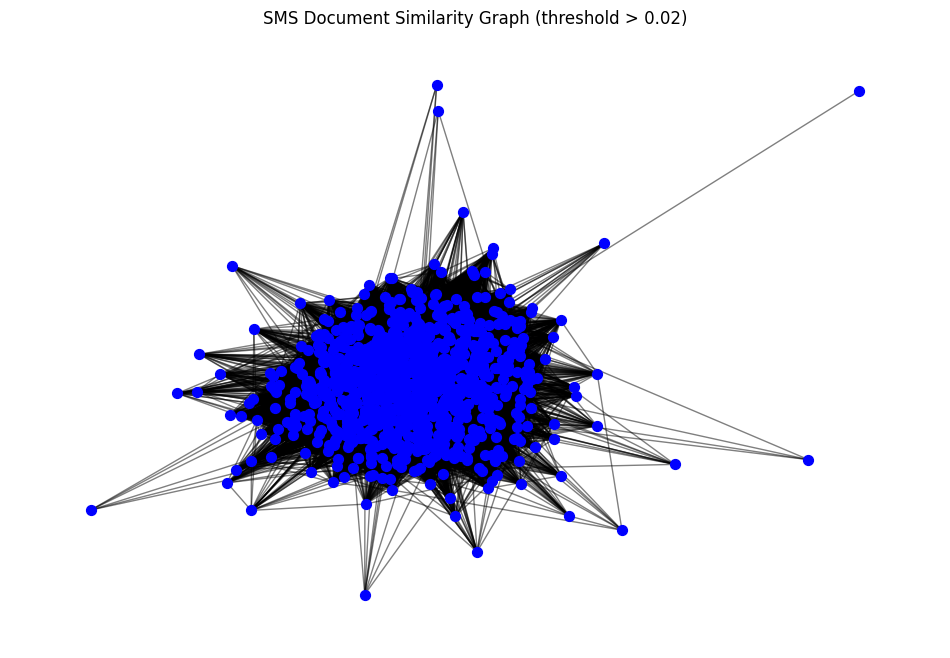

In [ ]:
import networkx as nx

G = nx.Graph()

# Add edges
for node, neighbors in graph.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for positioning
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("SMS Document Similarity Graph (threshold > 0.02)")
plt.axis('off')
plt.show()

Average PageRank Score by Label:
label
ham     0.001010
spam    0.000917
Name: pagerank, dtype: float64


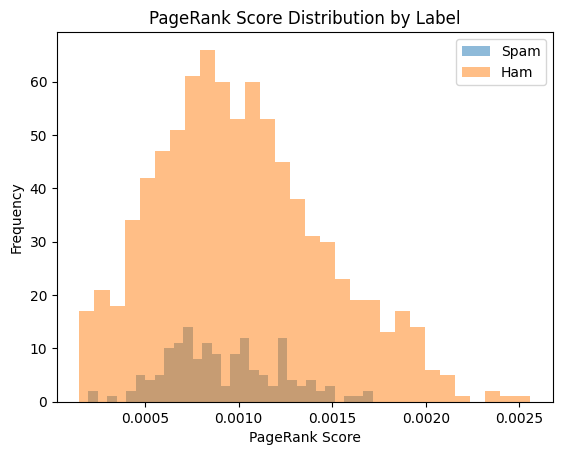

In [ ]:
###Comparing avarage page ranks for ham and spam

df['pagerank'] = pr

avg_pagerank_by_label = df.groupby('label')['pagerank'].mean()
print("Average PageRank Score by Label:")
print(avg_pagerank_by_label)

plt.hist(df[df['label'] == 'spam']['pagerank'], bins=30, alpha=0.5, label='Spam')
plt.hist(df[df['label'] == 'ham']['pagerank'],  bins=30, alpha=0.5, label='Ham')
plt.title('PageRank Score Distribution by Label')
plt.xlabel('PageRank Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import networkx as nx

def networkx_pagerank(graph_adj_list, damping=0.85, max_iter=100, tol=1e-6):
    G = nx.DiGraph()
    G.add_nodes_from(graph_adj_list.keys())

    # Add edges
    for node, neighbors in graph_adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    pr = nx.pagerank(G, alpha=damping, max_iter=max_iter, tol=tol)

    # Returns PageRank scores in order of node index
    return [pr.get(i, 0.0) for i in range(len(graph_adj_list))]


pr_networkx = networkx_pagerank(graph)

pr_mine = pageRank(graph)

# Compare side by side
for i in range(len(pr_mine)):
    print(f"Node {i}: My PR = {pr_mine[i]:.6f} vs NetworkX PR = {pr_networkx[i]:.6f}")

Node 0: My PR = 0.000761 vs NetworkX PR = 0.000764
Node 1: My PR = 0.000333 vs NetworkX PR = 0.000334
Node 2: My PR = 0.000609 vs NetworkX PR = 0.000612
Node 3: My PR = 0.000679 vs NetworkX PR = 0.000682
Node 4: My PR = 0.000785 vs NetworkX PR = 0.000789
Node 5: My PR = 0.001700 vs NetworkX PR = 0.001707
Node 6: My PR = 0.001124 vs NetworkX PR = 0.001129
Node 7: My PR = 0.000797 vs NetworkX PR = 0.000801
Node 8: My PR = 0.000810 vs NetworkX PR = 0.000814
Node 9: My PR = 0.001346 vs NetworkX PR = 0.001352
Node 10: My PR = 0.001783 vs NetworkX PR = 0.001791
Node 11: My PR = 0.000779 vs NetworkX PR = 0.000783
Node 12: My PR = 0.001063 vs NetworkX PR = 0.001068
Node 13: My PR = 0.001906 vs NetworkX PR = 0.001914
Node 14: My PR = 0.001384 vs NetworkX PR = 0.001390
Node 15: My PR = 0.000851 vs NetworkX PR = 0.000855
Node 16: My PR = 0.000711 vs NetworkX PR = 0.000714
Node 17: My PR = 0.000832 vs NetworkX PR = 0.000836
Node 18: My PR = 0.000746 vs NetworkX PR = 0.000749
Node 19: My PR = 0.000